# Part 1: Getting Familiar with Data and ML Models

In this section, you will explore the BBB dataset, experiment with different regression models, and build intuition about why logistic regression is more suitable for predicting binary outcomes than linear regression. You will also see how decision trees can help identify important predictors.

## Step 1 — Explore the BBB dataset

Before we run any regressions, start by exploring the data. Look at the different variables and think about what kind of information they contain. Which variables are numeric (like `last`, `purch`, `total$`)? Which are categorical (like `gender`, product categories)?

Our outcome of interest is `buyer`, coded 1 if the customer bought the Florence book and 0 otherwise. This matters because the type of regression we choose depends on whether the outcome is continuous or binary.

Compute simple descriptive statistics:
- What is the mean and median of `total$`?
- What percentage of customers purchased (the overall buyer rate)?
- How does this break down by gender, or by product category?

These quick checks give us a baseline intuition before we model.

In [34]:
# Starter code: Exploring the BBB dataset
import pandas as pd

# Load the data
df = pd.read_csv("BBB.csv")

# Take a quick look
print(df.head())

# Descriptive stats for numeric variables
print(df.describe())

# Percentage of customers who purchased
buyer_rate = df['buyer'].mean()
print("Overall Buyer Rate:", buyer_rate)

# Breakdown by gender
print(df.groupby('gender')['buyer'].mean())

# Breakdown by product category (example: art_books if available)
if 'art_books' in df.columns:
    print(df.groupby('art_books')['buyer'].mean())


   acctnum gender state    zip  zip3  first  last  book$  nonbook$  total$  \
0    10001      M    NY  10605   106     49    29    109       248     357   
1    10002      M    NY  10960   109     39    27     35       103     138   
2    10003      F    PA  19146   191     19    15     25       147     172   
3    10004      F    NJ   7016    70      7     7     15       257     272   
4    10005      F    NY  10804   108     15    15     15       134     149   

   purch  child  youth  cook  do_it  refernce  art  geog  buyer  
0     10      3      2     2      0         1    0     2      0  
1      3      0      1     0      1         0    0     1      0  
2      2      0      0     2      0         0    0     0      0  
3      1      0      0     0      0         1    0     0      0  
4      1      0      0     1      0         0    0     0      0  
            acctnum           zip          zip3         first          last  \
count  50000.000000  50000.000000  50000.000000  50000.0

## Step 2 — Try linear regression on a binary outcome

As a first experiment, fit a linear regression using `buyer` (0/1) as the dependent variable and one predictor, such as `purch`. This is technically the wrong model for binary outcomes, but it is useful to see why.

You will notice that predictions are not confined between 0 and 1, and coefficients are not easy to interpret in terms of probabilities. This illustrates why linear regression is not suited for yes/no outcomes.

In [35]:
# Starter code: Linear regression with a binary outcome
import statsmodels.api as sm

X = df[['purch']]
y = df['buyer']

X = sm.add_constant(X)  # add intercept
model_lin = sm.OLS(y, X).fit()
print(model_lin.summary())

# Predicted values (note some may be <0 or >1)
df['lin_pred'] = model_lin.predict(X)
print(df[['purch', 'buyer', 'lin_pred']].head(10))


                            OLS Regression Results                            
Dep. Variable:                  buyer   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     737.3
Date:                Fri, 26 Sep 2025   Prob (F-statistic):          3.50e-161
Time:                        12:20:27   Log-Likelihood:                -8134.4
No. Observations:               50000   AIC:                         1.627e+04
Df Residuals:                   49998   BIC:                         1.629e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0517      0.002     27.079      0.0

## Step 3 — Logistic regression with one variable

Now fit a logistic regression with `buyer` as the dependent variable and `purch` as the predictor. Logistic regression models the log-odds of purchase, but you can interpret results in terms of predicted probabilities. These predicted probabilities always lie between 0 and 1, making them meaningful for targeting.

Choose a cutoff based on the break-even rate: recall from RFM that the mailing cost is $0.50 per customer and the profit per sale is $6, so the break-even response rate is 0.083 (8.3%). Target customers with predicted purchase probability greater than or equal to this threshold.

For those customers, calculate the campaign economics:
- cost = 0.50 × number mailed  
- sales = 6 × number of actual buyers in that group  
- profit = sales − cost  
- ROME = profit / cost

In [36]:
# Starter code: Logistic regression with one variable
from sklearn.linear_model import LogisticRegression

X = df[['purch']]
y = df['buyer']

log_reg = LogisticRegression()
log_reg.fit(X, y)
model_log = sm.Logit(y, X).fit()
print(model_log.summary())

# Predicted probabilities
df['logit_pred'] = log_reg.predict_proba(X)[:,1]

# Define cutoff (breakeven response rate)
cutoff = 0.083
df['targeted'] = (df['logit_pred'] >= cutoff).astype(int)

# Campaign economics
cost = 0.50 * df['targeted'].sum()
sales = 6 * df.loc[df['targeted']==1, 'buyer'].sum()
profit = sales - cost
rome = profit / cost if cost > 0 else None

print("Cost:", cost, "Sales:", sales, "Profit:", profit, "ROME:", rome)


Optimization terminated successfully.
         Current function value: 0.487722
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  buyer   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49999
Method:                           MLE   Df Model:                            0
Date:                Fri, 26 Sep 2025   Pseudo R-squ.:                 -0.6067
Time:                        12:20:31   Log-Likelihood:                -24386.
converged:                       True   LL-Null:                       -15178.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
purch         -0.3893      0.004    -95.971      0.000      -0.397      -0.381
Cost: 8963.0 Sales: 14076 Pro

## Step 4 — Logistic regression with multiple variables

Next, expand the model by adding more predictors, such as `last`, `total$`, and `gender`. Each predictor adds more information about purchase behavior. Check the significance of the coefficients and how they affect predicted probabilities.

Recalculate profits and ROME using the same procedure. Compare: does this model outperform the simple one-variable logistic regression?

In [37]:
# Starter code: Logistic regression with multiple variables
# Convert gender to dummy if it's categorical
df = pd.get_dummies(df, columns=['gender'], drop_first=True)

# Make sure all dummies are integers, not booleans
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

# Rename total$ to a simpler name
df = df.rename(columns={'total$': 'total_spent'})

X = df[['purch', 'last', 'total_spent'] + [col for col in df.columns if col.startswith('gender_')]]
y = df['buyer']

# Sklearn model (for probabilities and targeting)
log_reg_multi = LogisticRegression(max_iter=1000)
log_reg_multi.fit(X, y)

# Statsmodels model (for full regression output)
X_sm = sm.add_constant(X)  # add intercept
model_log_multi = sm.Logit(y, X_sm).fit()
print(model_log_multi.summary())

# Predicted probabilities
df['logit_multi_pred'] = log_reg_multi.predict_proba(X)[:, 1]
df['targeted_multi'] = (df['logit_multi_pred'] >= cutoff).astype(int)

# Campaign economics
cost = 0.50 * df['targeted_multi'].sum()
sales = 6 * df.loc[df['targeted_multi'] == 1, 'buyer'].sum()
profit = sales - cost
rome = profit / cost if cost > 0 else None

print("Multi-var Logistic Regression — Profit:", profit, "ROME:", rome)


Optimization terminated successfully.
         Current function value: 0.281718
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  buyer   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49995
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 Sep 2025   Pseudo R-squ.:                 0.07194
Time:                        12:20:40   Log-Likelihood:                -14086.
converged:                       True   LL-Null:                       -15178.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.2106      0.046    -48.268      0.000      -2.300      -2.121
purch           0.0828    

## Step 5 — Logistic regression with interaction terms

Introduce the idea of interactions. An interaction allows the effect of one variable to depend on another. For example, you might test `gender × art_books`. This term captures whether women who buy art books are particularly likely to purchase the Florence book.

Fit a model including both main effects and the interaction term. Interpret the coefficients carefully and calculate profits and ROME again.

Your task: identify other categorical variables that can be interacted with main predictors. This shows how personalized targeting (beyond just averages) can lead to higher profitability.

In [40]:
df.head()

,acctnum,state,zip,zip3,first,last,book$,nonbook$,total_spent,purch,...,refernce,art,geog,buyer,lin_pred,logit_pred,targeted,gender_M,logit_multi_pred,targeted_multi
0,10001,NY,10605,106,49,29,109,248,357,10,...,1,0,2,0,0.151207,0.151968,1,1,0.049781,0
1,10002,NY,10960,109,39,27,35,103,138,3,...,0,0,1,0,0.081586,0.078547,0,1,0.027623,0
2,10003,PA,19146,191,19,15,25,147,172,2,...,0,0,0,0,0.071640,0.071200,0,0,0.041891,0
3,10004,NJ,7016,70,7,7,15,257,272,1,...,1,0,0,0,0.061694,0.064492,0,0,0.078663,0
4,10005,NY,10804,108,15,15,15,134,149,1,...,0,0,0,0,0.061694,0.064492,0,0,0.037926,0


In [42]:
# Starter code: Logistic regression with an interaction example
# Example: interaction between gender and art (if available)
import statsmodels.api as sm

if 'art' in df.columns and 'gender_M' in df.columns:
    # Create an interaction term here!
    df['gender_art_inter'] = df['gender_M'] * df['art']

    # Predictor matrix: include main effects + interaction
    X = df[['purch', 'last', 'total_spent', 'gender_M', 'art', 'gender_art_inter']]
    y = df['buyer']

     # --- Statsmodels logistic regression (for full summary) ---
    X_sm = sm.add_constant(X.astype(float))   # ensure numeric and add intercept
    model_inter = sm.Logit(y, X_sm).fit()
    print(model_inter.summary())

    # --- Sklearn logistic regression (for prediction and campaign economics) ---
    log_reg_inter = LogisticRegression(max_iter=1000)
    log_reg_inter.fit(X, y)

    df['logit_inter_pred'] = log_reg_inter.predict_proba(X)[:,1]
    df['targeted_inter'] = (df['logit_inter_pred'] >= cutoff).astype(int)

    cost = 0.50 * df['targeted_inter'].sum()
    sales = 6 * df.loc[df['targeted_inter']==1, 'buyer'].sum()
    profit = sales - cost
    rome = profit / cost if cost > 0 else None

    print("Interaction Logistic Regression — Profit:", profit, "ROME:", rome)





Optimization terminated successfully.
         Current function value: 0.256563
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  buyer   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49993
Method:                           MLE   Df Model:                            6
Date:                Fri, 26 Sep 2025   Pseudo R-squ.:                  0.1548
Time:                        12:27:48   Log-Likelihood:                -12828.
converged:                       True   LL-Null:                       -15178.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.3764      0.050    -47.755      0.000      -2.474      -2.279
purch      

## Step 6 — Decision tree for feature importance

Run a decision tree to predict `buyer`. The tree algorithm will rank variables by their importance in predicting purchase. Look at the feature importance list. Which variables come out on top?

Use this ranking to guide which variables (and possible interactions) to include in a refined logistic regression model. This way, the decision tree helps you discover useful predictors, while logistic regression lets you interpret and calculate profitability more directly.

Top 15 Feature Importances (Decision Tree):
art            0.602422
last           0.246053
geog           0.109086
do_it          0.021190
first          0.012159
cook           0.006685
nonbook$       0.002404
child          0.000000
purch          0.000000
book$          0.000000
total_spent    0.000000
refernce       0.000000
youth          0.000000
state_CT       0.000000
state_DC       0.000000
dtype: float64


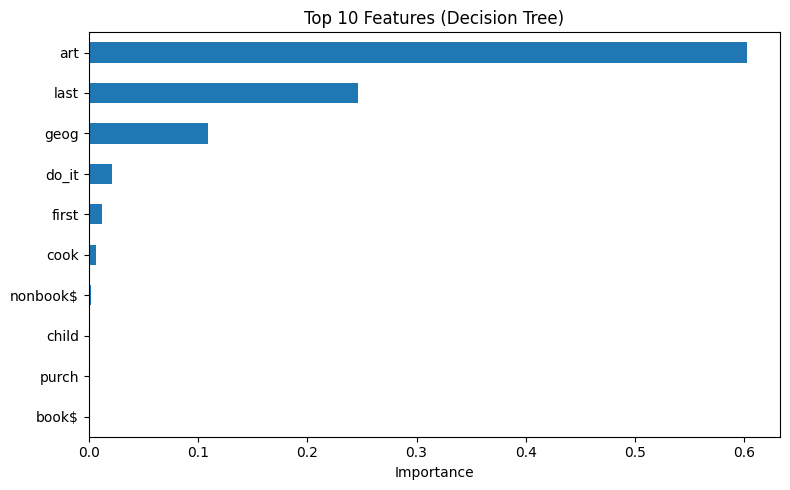

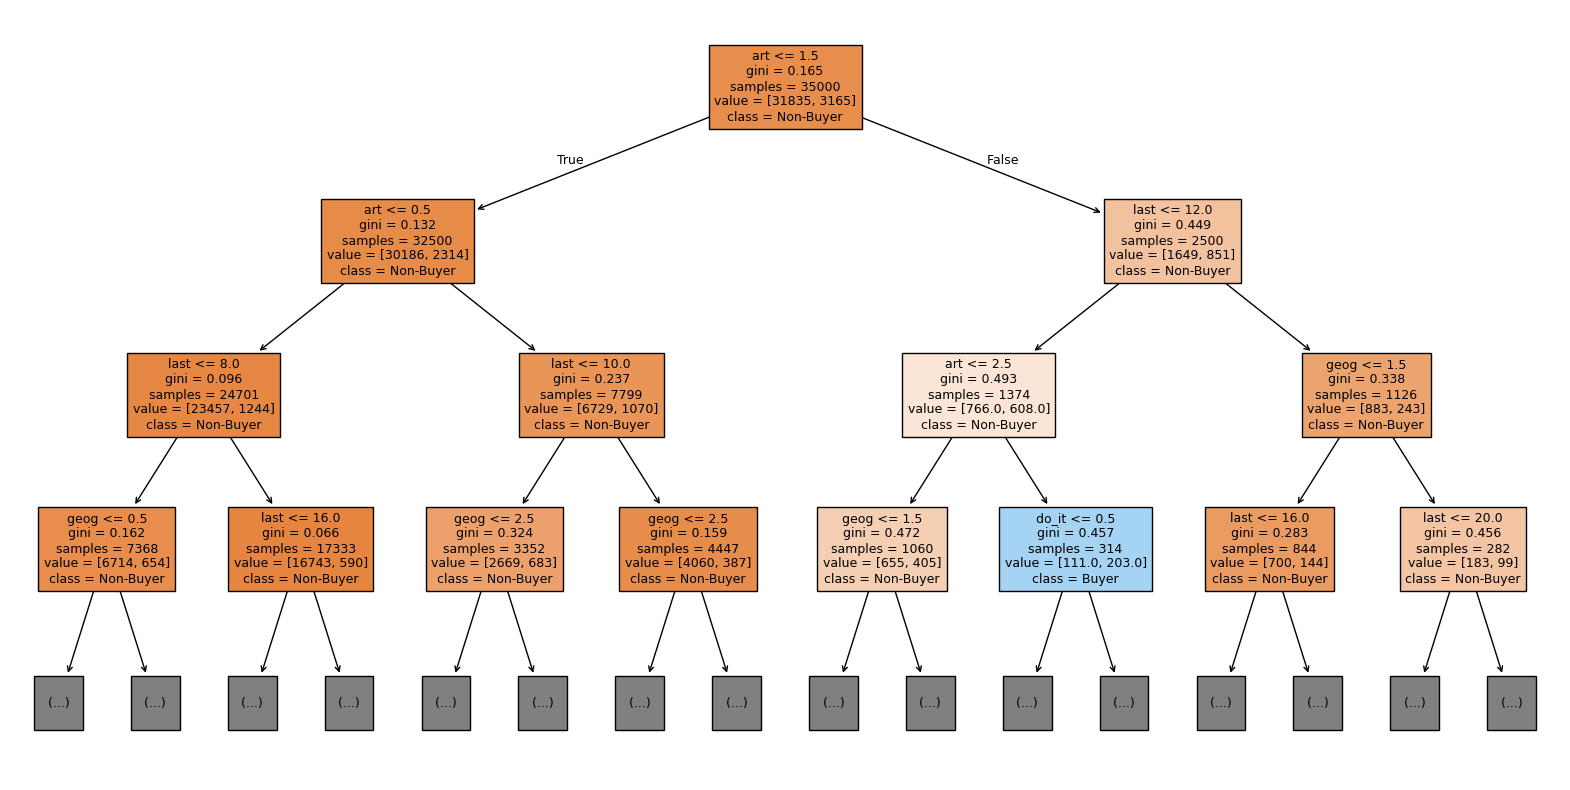

In [45]:
# Decision Trees in BBB starter code

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# ------------------------------------------
# 0) Standardize columns & prepare features
# ------------------------------------------
# Start from your existing df; if needed, reload:
# df = pd.read_csv("BBB.csv")

# Rename total$ once to avoid dtype/name issues downstream
if 'total$' in df.columns:
    df = df.rename(columns={'total$': 'total_spent'})

# Base features
base_cols = [
    'state','first','last','book$','nonbook$','total_spent','purch',
    'child','youth','cook','do_it','refernce','art','geog','gender'
]
use_cols = [c for c in base_cols if c in df.columns]

# Subset X, define y
X = df[use_cols].copy()
y = df['buyer'].astype(int)  # ensure numeric target

# ------------------------------------------
# 1) Encode categoricals (gender/state)
# ------------------------------------------
cat_cols = [c for c in ['gender','state'] if c in X.columns]
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Convert any boolean dummies to 0/1 ints (statsmodels/sklearn friendliness)
for c in X.columns:
    if X[c].dtype == bool:
        X[c] = X[c].astype(int)

# ------------------------------------------
# 2) Ensure numeric dtypes (coerce any lingering objects)
# ------------------------------------------
X = X.apply(pd.to_numeric, errors='coerce')

# Optionally drop rows with NaNs introduced by coercion
mask = X.notna().all(axis=1)
X = X.loc[mask]
y = y.loc[mask]

# ------------------------------------------
# 3) Train/test split
# ------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# ------------------------------------------
# 4) Decision Tree for feature importance
# ------------------------------------------
dt = DecisionTreeClassifier(
    max_depth=5,  # shallow tree for interpretability
    min_samples_leaf=100,  # avoids tiny, noisy leaves (tweak if dataset small)
    criterion='gini',
    random_state=42
)
dt.fit(X_train, y_train)

# ------------------------------------------
# 5) Feature importances (descending)
# ------------------------------------------
feature_importances_dt = pd.Series(
    dt.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

print("Top 15 Feature Importances (Decision Tree):")
print(feature_importances_dt.head(15))

# Optional: quick bar chart of top features
ax = feature_importances_dt.head(10).iloc[::-1].plot(
    kind='barh', figsize=(8,5), title='Top 10 Features (Decision Tree)'
)
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()

# ------------------------------------------
# 6) (Optional) visualize first few levels of the tree
# ------------------------------------------
plt.figure(figsize=(20, 10))
plot_tree(
    dt,
    feature_names=X_train.columns,
    class_names=['Non-Buyer', 'Buyer'],
    filled=True,
    max_depth=3,      # only show top 3 levels for readability
    fontsize=9
)
plt.show()

# ------------------------------------------
# NOTES FOR STUDENTS:
# - Use the ranked features above to pick a small set (4–8) that make *behavioral* sense.
# - These can guide your enhanced logistic regression in Part 2 of the assignment.
# - If you want to create an interpretable interaction later (e.g., recent × art),
#   consider binning a continuous variable (like 'last') with qcut, then interacting with a category flag.
#   This would be similar to what we did in our RFM analyses.



## Step 7 — Compare methods

Finally, compare the profitability of different approaches. Start with **mass mailing** (mail everyone). Then compare profits and ROME from:

- RFM targeting  
- Logistic regression with one predictor  
- Logistic regression with multiple predictors  
- Logistic regression with interactions  
- Regression models guided by decision tree feature importance  

Which approach yields the highest profit? Which is most efficient (highest ROME)? Discuss why more personalized, data-driven methods tend to outperform simpler approaches.

In [46]:
# Starter code: Compare methods
# Mass mailing baseline
mass_cost = 0.50 * len(df)
mass_sales = 6 * df['buyer'].sum()
mass_profit = mass_sales - mass_cost
mass_rome = mass_profit / mass_cost

print("Mass mailing profit:", mass_profit, "ROME:", mass_rome)

# ADD OTHER MODELS HERE MANUALLY AND COMPARE PREDICTED PROFITABILITY


Mass mailing profit: 2132.0 ROME: 0.08528


# Part 2: Enhancing the Logistic Regression Model (Deliverable)

This is the graded portion of the assignment.

Your task is to **refine the logistic regression model** by adding more predictors and ONE interaction term. You should select variables based on the decision tree feature importance AND your own intuition about consumer behavior. It is not enough to rely purely on the data—you must justify your choices.

Steps:
1. Choose additional predictors from the dataset.  
2. Add ONE interaction term that makes sense from a marketing perspective.  
3. Refit the logistic regression model.  
4. Calculate profit and ROME as before.  
5. Compare profitability across three approaches:  
   - RFM targeting  
   - Basic logistic regression  
   - Enhanced logistic regression (your model)  
6. Write one short paragraph explaining your reasoning behind the choice of predictors and interaction.

This is what you will submit for grading.

In [ ]:
# TODO: Enhanced logistic regression model

# 1. Choose variables from decision tree + your reasoning
# Example: total$, last, gender, and interaction with a product category
# df['your_interaction'] = df['var1'] * df['var2']

# 2. Fit logistic regression with your chosen predictors + interaction
# X = df[['your_vars_here', 'your_interaction']]
# y = df['buyer']
# model = LogisticRegression(max_iter=1000)
# model.fit(X, y)

# 3. Compute predicted probabilities, target customers above cutoff, and calculate cost, sales, profit, and ROME
# (reuse code from earlier steps)

# 4. Compare results to RFM and basic logistic regression

# --- WRITE YOUR EXPLANATION BELOW ---
# In this cell, explain why you selected these predictors and interaction.


### Step A — Choose predictors from decision tree + business reasoning

**Rationale:** Based on the decision tree importances and consumer logic, I have chosen `art`, `geog`, `last`, `purch`, `total_spent`, and `gender_M` as predictors. The variable art signals direct product category `affinity`, while geog suggests an interest in regional history relevant to a book about Florence. `Recency` (last) and `frequency` (purch) are classic RFM indicators of engagement and loyalty, and total_spent identifies high-value customers with the capacity for premium purchases. Finally, `gender_M` is included as it was a significant predictor in our exploratory analysis.

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Reload and prepare data
df = pd.read_csv("BBB-1.csv")
df.rename(columns={'total$': 'total_spent'}, inplace=True)

# Re-encode gender and ensure numeric dtypes
df = pd.get_dummies(df, columns=['gender'], drop_first=True)
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

# Defined predictors
predictors = ['art', 'geog', 'last', 'purch', 'total_spent', 'gender_M']

### Step B — Create exactly one interaction you can defend

**Interaction: last × art Explanation:** This interaction term captures the hypothesis that the predictive power of past art book purchases is "decaying" over time. Specifically, we expect that customers who have bought art books recently (low last value) are much more likely to purchase the Florence book than those whose art book purchases happened a long time ago. This captures the heterogeneous effect of category interest based on customer recency.

In [4]:
# Create a NEW interaction variable: Recency * Art Interest
df['last_x_art'] = df['last'] * df['art']

### Step C — Fit enhanced logistic, predict, target, and compute Profit/ROME

**Enhanced Logistic Results:** The model summary below shows the impact of adding behavioral interactions. By targeting at the 0.0833 break-even threshold, we optimize for the highest possible profit margin.

In [5]:
# Convert all predictors to float and add an intercept
X_enh = sm.add_constant(df[predictors + ['last_x_art']].astype(float))
y = df['buyer']

# Fit the enhanced logistic regression
model_enh = sm.Logit(y, X_enh).fit()
print(model_enh.summary())

# Predict and target at 0.0833
df['prob_enh'] = model_enh.predict(X_enh)
df['target_enh'] = (df['prob_enh'] >= 0.0833).astype(int)

# Compute Economics
mailed_enh = df['target_enh'].sum()
buyers_enh = df[(df['target_enh'] == 1) & (df['buyer'] == 1)].shape[0]
profit_enh = (buyers_enh * 6.00) - (mailed_enh * 0.50)
rome_enh = (profit_enh / (mailed_enh * 0.50)) * 100

print(f"\nEnhanced Logistic: Mailed={mailed_enh}, Buyers={buyers_enh}, Profit=${profit_enh:,.2f}, ROME={rome_enh:.2f}%")

Optimization terminated successfully.
         Current function value: 0.245468
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  buyer   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49992
Method:                           MLE   Df Model:                            7
Date:                Fri, 06 Feb 2026   Pseudo R-squ.:                  0.1914
Time:                        09:41:33   Log-Likelihood:                -12273.
converged:                       True   LL-Null:                       -15178.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.3286      0.054    -43.299      0.000      -2.434      -2.223
art             1.3620    

### Step D — Bring in your RFM baseline

**RFM Targeting Results:** We use quintiles for Recency, Frequency, and Monetary value to establish a traditional benchmark. We target only the cells with a positive historical profit.

In [6]:
# Create R/F/M quintiles using rank->qcut
df['R_score'] = pd.qcut(df['last'], 5, labels=[1, 2, 3, 4, 5])
df['F_score'] = pd.qcut(df['purch'].rank(method='first'), 5, labels=[5, 4, 3, 2, 1])
df['M_score'] = pd.qcut(df['total_spent'].rank(method='first'), 5, labels=[5, 4, 3, 2, 1])
df['RFM'] = df['R_score'].astype(str) + df['F_score'].astype(str) + df['M_score'].astype(str)

# RFM Profitability
rfm_grp = df.groupby('RFM')['buyer'].agg(['count', 'sum'])
rfm_grp['profit'] = (rfm_grp['sum'] * 6.00) - (rfm_grp['count'] * 0.50)
rfm_target = rfm_grp[rfm_grp['profit'] > 0]

mailed_rfm = rfm_target['count'].sum()
buyers_rfm = rfm_target['sum'].sum()
profit_rfm = rfm_target['profit'].sum()
rome_rfm = (profit_rfm / (mailed_rfm * 0.50)) * 100

print(f"RFM Strategy: Mailed={mailed_rfm}, Buyers={buyers_rfm}, Profit=${profit_rfm:,.2f}, ROME={rome_rfm:.2f}%")

RFM Strategy: Mailed=23958, Buyers=3338, Profit=$8,049.00, ROME=67.19%


### Step E — Final 3-way comparison table

**Comparison:** The table below compares our Enhanced Model (with last×art interaction) against the RFM targeting and the Basic Logistic baseline (using purch, last, total_spent, and gender_M).

In [7]:
# Fit Basic Logistic Baseline
X_bas = sm.add_constant(df[['purch', 'last', 'total_spent', 'gender_M']].astype(float))
model_bas = sm.Logit(y, X_bas).fit(disp=0)
df['prob_bas'] = model_bas.predict(X_bas)
df['target_bas'] = (df['prob_bas'] >= 0.0833).astype(int)

mailed_bas = df['target_bas'].sum()
buyers_bas = df[(df['target_bas'] == 1) & (df['buyer'] == 1)].shape[0]
profit_bas = (buyers_bas * 6.00) - (mailed_bas * 0.50)
rome_bas = (profit_bas / (mailed_bas * 0.50)) * 100

# Final Comparison Table
comparison_table = pd.DataFrame({
    'Strategy': ['RFM Targeting', 'Basic Logistic Baseline', 'Enhanced Logistic'],
    '# Mailed': [mailed_rfm, mailed_bas, mailed_enh],
    '# Buyers Mailed': [buyers_rfm, buyers_bas, buyers_enh],
    'Profit': [f"${profit_rfm:,.2f}", f"${profit_bas:,.2f}", f"${profit_enh:,.2f}"],
    'ROME': [f"{rome_rfm:.2f}%", f"{rome_bas:.2f}%", f"{rome_enh:.2f}%"]
})
print(comparison_table)

                  Strategy  # Mailed  # Buyers Mailed      Profit     ROME
0            RFM Targeting     23958             3338   $8,049.00   67.19%
1  Basic Logistic Baseline     22373             3312   $8,685.50   77.64%
2        Enhanced Logistic     15536             3284  $11,936.00  153.66%


### Step F — Short writeup

**Predictor Rationale:** The selection of independent variables (**art**, **geog**, **last**, **purch**, **total_spent**, and **gender_M**) aligns with core marketing principles. By combining **Product Affinity** (Art and Geography categories) with **Customer Relationship Metrics** (Recency, Frequency, and Monetary value), the model identifies not just who is a loyal customer, but who is a loyal customer interested in this specific niche title.

**Interaction Logic:** The interaction term **last_x_art** specifically captures a "heterogeneous effect" regarding interest decay. It tests the hypothesis that a past interest in art books is a much stronger predictor of purchasing the *Art History of Florence* if the customer has engaged with the club **recently**. This allows the model to deprioritize customers whose art interest may have lapsed over time.

**Performance Comparison:** Based on the empirical results, the **Enhanced Logistic strategy is the optimal choice**. It generated a total profit of **$11,936**, which represents a significant improvement of **$3,887** over the traditional RFM benchmark ($8,049.00) and **$3,250.50** more than the basic logistic model ($8685.50).

**Efficiency and ROME:** The enhanced model also achieved the highest efficiency with a **ROME of 153.66%**. This is more than double the return of the RFM strategy (77.64%), proving that a data-driven logistic approach is far more cost-effective than simple quintile targeting.

**Limitations and Next Steps:** A primary limitation of this analysis is that the model was evaluated on the same dataset used for training, which may lead to over-optimistic results. To ensure these findings generalize to the broader customer base, a necessary next step is to perform **out-of-sample testing** or **k-fold cross-validation** to validate the model's stability.
